In [2]:
# Dependencies
import os
import requests
import pandas as pd
from config import gmaps_key
from pprint import pprint
import gmaps
import matplotlib.pyplot as plt

In [3]:
# Import google API key
from config import gmaps_key
# Setup Google Maps API
gmaps.configure(api_key=gmaps_key)

In [4]:
# Combine raw data into a data frame
yrs_15to18_path = os.path.join("data","crash_data_2015-2018.csv")
yrs_19to21_path = os.path.join("data","crash_data_2019-2021.csv")
years_15to18 = pd.read_csv(yrs_15to18_path)
years_19to21 = pd.read_csv(yrs_19to21_path)
crash_df = pd.concat([years_19to21,years_15to18],ignore_index=True)
crash_df

,CRASH_DATE,CRASH_TIME,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,ALIGNMENT,...,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,STREET_DIRECTION,NUM_UNITS,MOST_SEVERE_INJURY,INJURIES_TOTAL,INJURIES_FATAL,CRASH_HOUR,LATITUDE,LONGITUDE
0,1/7/2021,3:00,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,...,UNABLE TO DETERMINE,UNABLE TO DETERMINE,W,3,NO INDICATION OF INJURY,0.0,0.0,3,41.924260,-87.753029
1,1/7/2021,0:30,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",ANGLE,FOUR WAY,STRAIGHT AND LEVEL,...,DISREGARDING TRAFFIC SIGNALS,UNABLE TO DETERMINE,N,2,NONINCAPACITATING INJURY,1.0,0.0,0,41.902701,-87.711526
2,1/7/2021,0:26,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",TURNING,FOUR WAY,STRAIGHT AND LEVEL,...,FAILING TO YIELD RIGHT-OF-WAY,NOT APPLICABLE,N,3,NO INDICATION OF INJURY,0.0,0.0,0,41.935010,-87.756408
3,1/7/2021,0:07,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",FIXED OBJECT,DIVIDED - W/MEDIAN BARRIER,STRAIGHT AND LEVEL,...,DISREGARDING TRAFFIC SIGNALS,NOT APPLICABLE,S,1,NONINCAPACITATING INJURY,2.0,0.0,0,41.838327,-87.617613
4,1/6/2021,23:21,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",ANGLE,FOUR WAY,STRAIGHT AND LEVEL,...,DISREGARDING TRAFFIC SIGNALS,NOT APPLICABLE,W,2,NO INDICATION OF INJURY,0.0,0.0,23,41.881926,-87.745462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467652,8/4/2015,8:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,NOT DIVIDED,STRAIGHT AND LEVEL,...,DISREGARDING TRAFFIC SIGNALS,DISREGARDING TRAFFIC SIGNALS,S,2,"REPORTED, NOT EVIDENT",1.0,0.0,8,41.816471,-87.621551
467653,8/4/2015,5:00,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,ONE-WAY,STRAIGHT AND LEVEL,...,UNABLE TO DETERMINE,NOT APPLICABLE,N,2,NO INDICATION OF INJURY,0.0,0.0,5,41.881057,-87.771673
467654,8/3/2015,18:37,35,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,NOT DIVIDED,STRAIGHT AND LEVEL,...,FOLLOWING TOO CLOSELY,UNABLE TO DETERMINE,N,2,NO INDICATION OF INJURY,0.0,0.0,18,41.896980,-87.656687
467655,8/3/2015,15:30,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,...,"EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST",FOLLOWING TOO CLOSELY,N,2,NO INDICATION OF INJURY,0.0,0.0,15,41.912188,-87.680491


In [5]:
crash_columns = crash_df.columns
print(crash_columns)

Index(['CRASH_DATE', 'CRASH_TIME', 'POSTED_SPEED_LIMIT',
       'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 'WEATHER_CONDITION',
       'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE',
       'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'CRASH_TYPE',
       'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DAMAGE', 'DATE_POLICE_NOTIFIED',
       'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'STREET_DIRECTION',
       'NUM_UNITS', 'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL',
       'CRASH_HOUR', 'LATITUDE', 'LONGITUDE'],
      dtype='object')


#### What impacts crash type the most? - Romi

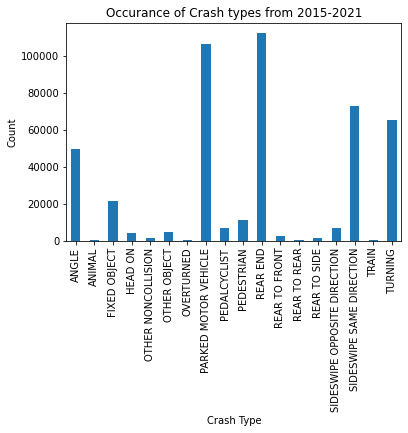

<Figure size 432x288 with 0 Axes>

In [6]:
# Create first crash type bar graph
grouped_crahses = crash_df.groupby(["FIRST_CRASH_TYPE"])
crash_count = grouped_crahses["FIRST_CRASH_TYPE"].count()
crash_chart = crash_count.plot(kind='bar')
crash_chart.set_xlabel("Crash Type")
crash_chart.set_ylabel("Count")
crash_chart.set_title("Occurance of Crash types from 2015-2021")
plt.show()
plt.tight_layout()

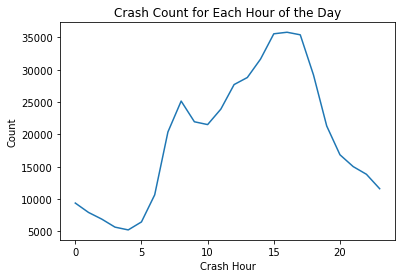

<Figure size 432x288 with 0 Axes>

In [7]:
# Create crash count per hour (histogram/line)
crashes_per_hour_grouped = crash_df.groupby(["CRASH_HOUR"])
hour_count = crashes_per_hour_grouped["CRASH_HOUR"].count()
hour_chart = hour_count.plot(kind='line')
hour_chart.set_xlabel("Crash Hour")
hour_chart.set_ylabel("Count")
hour_chart.set_title("Crash Count for Each Hour of the Day")
plt.show()
plt.tight_layout()

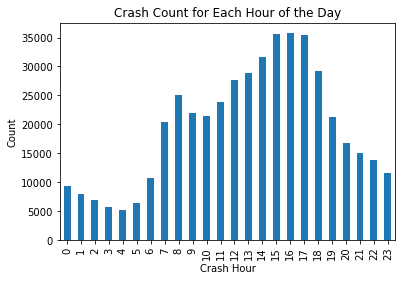

<Figure size 432x288 with 0 Axes>

In [8]:
hour_chart = hour_count.plot(kind='bar')
hour_chart.set_xlabel("Crash Hour")
hour_chart.set_ylabel("Count")
hour_chart.set_title("Crash Count for Each Hour of the Day")
plt.show()
plt.tight_layout()

[]

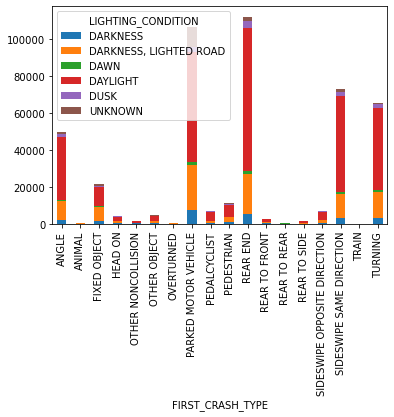

In [9]:
# Create first crash type vs. lighting graph (stacked bar graph)
lighting_crash_plot = crash_df.groupby(['FIRST_CRASH_TYPE', 'LIGHTING_CONDITION']).size().unstack().plot(kind='bar', stacked=True)
plt.plot()

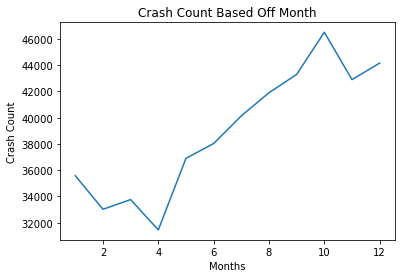

<Figure size 432x288 with 0 Axes>

In [10]:
# Create hit and run vs month (line) -analysis correlation to holidays
new_crash_df = crash_df
new_crash_df['Month'] = pd.DatetimeIndex(new_crash_df['CRASH_DATE']).month
month_grouped = new_crash_df.groupby(["Month"])
month_count = month_grouped["Month"].count()
month_chart = month_count.plot(kind='line')
month_chart.set_xlabel("Months")
month_chart.set_ylabel("Crash Count")
month_chart.set_title("Crash Count Based Off Month")
plt.show()
plt.tight_layout()

#### What type of injuries are caused by what types of crashes? - Jonathan

In [ ]:
# Create cost of damage and injury count (pie chart)
damage_group = crash_df.groupby("DAMAGE")
injury_count = damage_group["INJURIES_TOTAL"].count()
damage_inj_df = pd.DataFrame(injury_count)                            

#damage_inj_df

labels = list(damage_inj_df.index.values)
injuries = damage_inj_df["INJURIES_TOTAL"]
explode = (0,0,0.1)
#print(damage_inj_df.index)

plt.pie(injuries, labels=labels, autopct="%1.1f%%", shadow=True, explode=explode)
plt.title("Injury % by Cost of Damage Groups")
plt.axis('equal')
#plt.xlabel("Cost of Damage")
#plt.ylabel("Injury Count")

plt.savefig("output_data/injuries_by_cost_of_damage_group.png")

In [ ]:
# Create cost of damage and fatal injury count (scatter with regression)
fatal_count = damage_group["INJURIES_FATAL"].count()
damages_fatal_df = pd.DataFrame(fatal_count)

#print(damages_fatal_df)
x_labels = list(damage_inj_df.index.values)
y_values = fatal_count

plt.bar(x_labels, y_values, color=["yellow", "orange", "tomato"], edgecolor="black")
plt.title("Cost of Damage vs. # of Fatal Injuries")
plt.xlabel("Cost of Damage Group")
plt.ylabel("# of Fatal Injuries")

plt.savefig("output_data/cost_of_damage_vs_fatalities.png")

In [ ]:
# Create speed vs. fatality count (scatter with regression)

#### What types of wrecks occur based off location? - Bankston

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

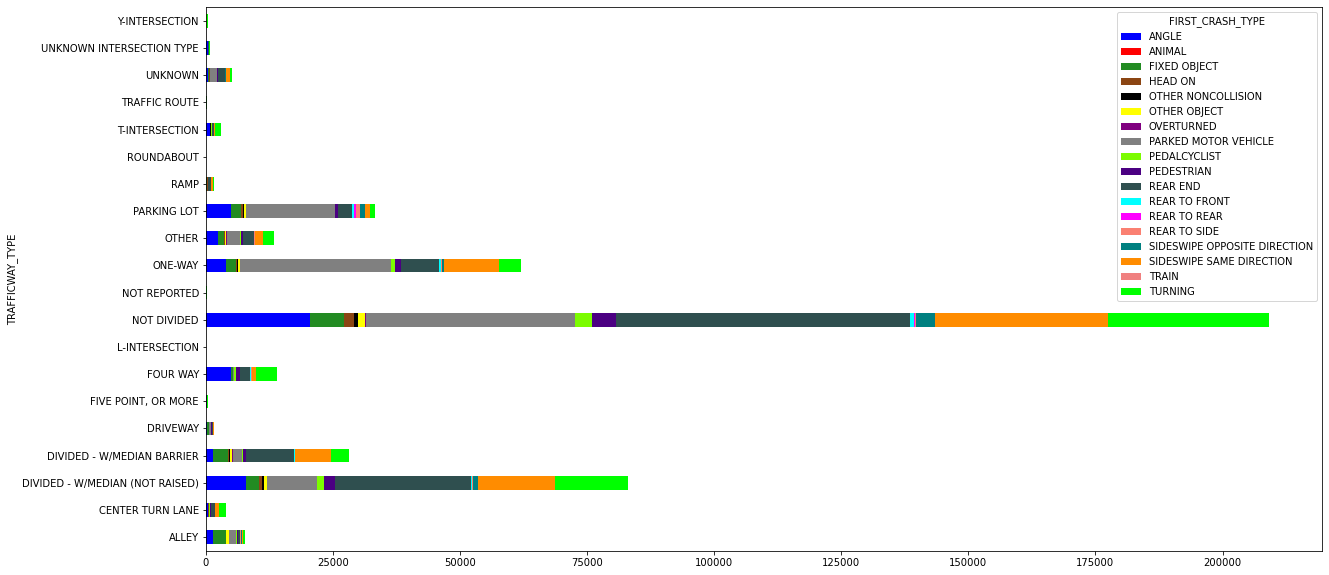

In [6]:
# Create bar graph for trafficway_type
# Need to possibly resize or breakup bars into groups
trafficway_crash_group = crash_df.groupby(['TRAFFICWAY_TYPE', 'FIRST_CRASH_TYPE']).size().unstack()
trafficway_crash_group.plot.barh(stacked = True, figsize = (20, 10), color=['blue', 'red', 'forestgreen', 'saddlebrown', 'black', 'yellow', 'purple', 'gray', 'lawngreen', 'indigo', 'darkslategray', 'aqua', 'fuchsia', 'salmon', 'teal', 'darkorange', 'lightcoral', 'lime'])
plt.plot

# Analysis of above: Lack of barriers seem to go with more crashes. Crashes are mostly rear-ending and sideswipe in the same direction

In [ ]:
# duplicate crash locations
duplicate_locations = crash_wInjury_df[crash_wInjury_df.duplicated(['LATITUDE', 'LONGITUDE'], keep = False)]
duplicate_locations.sort_values(['LATITUDE', 'LONGITUDE']).head(50)

In [8]:
# Remove non-applicable coordinates (NaN and outside city limits) & include injury data
locdata = crash_df.loc[(crash_df["LATITUDE"] >= 41) & \
                                  (crash_df["LATITUDE"] <= 43) & \
                                  (crash_df["LONGITUDE"] >= -88) & \
                                  (crash_df["LONGITUDE"] <= -87), ["LATITUDE","LONGITUDE","INJURIES_TOTAL","INJURIES_FATAL"]]

In [9]:
# assign coordinates to sections in 10x10 geographical grid 
sections = 10
locdata["LAT_BIN"] = pd.qcut(locdata["LATITUDE"], sections, labels=False) + 1
locdata["LNG_BIN"] = pd.qcut(locdata["LONGITUDE"], sections, labels=False) + 1
locdata["BOX_NUM"] = locdata["LNG_BIN"] + (sections * (locdata["LAT_BIN"]-1))
locdata

,LATITUDE,LONGITUDE,INJURIES_TOTAL,INJURIES_FATAL,LAT_BIN,LNG_BIN,BOX_NUM
0,41.924260,-87.753029,0.0,0.0,8,2,72
1,41.902701,-87.711526,1.0,0.0,7,3,63
2,41.935010,-87.756408,0.0,0.0,8,2,72
3,41.838327,-87.617613,2.0,0.0,4,9,39
4,41.881926,-87.745462,0.0,0.0,6,2,52
...,...,...,...,...,...,...,...
467652,41.816471,-87.621551,1.0,0.0,4,9,39
467653,41.881057,-87.771673,0.0,0.0,6,1,51
467654,41.896980,-87.656687,0.0,0.0,7,7,67
467655,41.912188,-87.680491,0.0,0.0,8,5,75


In [10]:
# create new dataframe with total injuries per box
injury_per_box = pd.DataFrame({})
box_group = locdata.groupby('BOX_NUM')
injury_per_box['INJURIES_TOTAL'] = box_group['INJURIES_TOTAL'].sum()
injury_per_box['INJURIES_FATAL'] = box_group['INJURIES_FATAL'].sum()
injury_per_box

,INJURIES_TOTAL,INJURIES_FATAL
BOX_NUM,,
2,64.0,2.0
3,262.0,1.0
4,273.0,5.0
5,581.0,3.0
6,968.0,6.0
...,...,...
93,406.0,2.0
94,1035.0,3.0
95,901.0,2.0


In [11]:
# generate coordinate for each square based on the average latitude and longitude of all crashes in that square
injury_per_box["LAT"] = ""
injury_per_box["LNG"] = ""
for box in list(injury_per_box.index):
    box_df = locdata.loc[locdata["BOX_NUM"] == box,["LATITUDE","LONGITUDE"]]
    injury_per_box.loc[box,"LAT"] = box_df["LATITUDE"].mean()
    injury_per_box.loc[box,"LNG"] = box_df["LONGITUDE"].mean()
injury_per_box

,INJURIES_TOTAL,INJURIES_FATAL,LAT,LNG
BOX_NUM,,,,
2,64.0,2.0,41.7216,-87.738
3,262.0,1.0,41.7104,-87.7188
4,273.0,5.0,41.7054,-87.7009
5,581.0,3.0,41.7081,-87.6811
6,968.0,6.0,41.7094,-87.6641
...,...,...,...,...
93,406.0,2.0,41.9836,-87.7175
94,1035.0,3.0,41.9938,-87.6992
95,901.0,2.0,41.997,-87.6825


In [12]:
# Create heat map for total injuries by location
fig_lat = locdata["LATITUDE"].median()
fig_lng = locdata["LONGITUDE"].median()
fig = gmaps.figure(layout={"height":"900px","width":"600px"},center=(fig_lat, fig_lng),zoom_level=11)
box_coordinates = injury_per_box[["LAT","LNG"]]
intensity = injury_per_box["INJURIES_TOTAL"]
heat_layer = gmaps.heatmap_layer(box_coordinates, weights=intensity, dissipating=False, max_intensity=intensity.max(), point_radius=.03)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='900px', width='600px'))

In [13]:
# Create heat map for fatal injuries by location
fig_lat = locdata["LATITUDE"].median()
fig_lng = locdata["LONGITUDE"].median()
fig = gmaps.figure(layout={"height":"900px","width":"600px"},center=(fig_lat, fig_lng),zoom_level=11)
box_coordinates = injury_per_box[["LAT","LNG"]]
intensity = injury_per_box["INJURIES_FATAL"]
heat_layer = gmaps.heatmap_layer(box_coordinates, weights=intensity, dissipating=False, max_intensity=intensity.max(), point_radius=.03)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='900px', width='600px'))

#### Create heat map of crashes by location with location of high schools plotted - Baker

In [5]:
# Remove non-applicable coordinates (NaN and outside city limits)
locdata = crash_df.loc[(crash_df["LATITUDE"] >= 41) & \
                                  (crash_df["LATITUDE"] <= 43) & \
                                  (crash_df["LONGITUDE"] >= -88) & \
                                  (crash_df["LONGITUDE"] <= -87), ["LATITUDE","LONGITUDE"]]

*Bin crashes into 25 equally sized boxes by geography:*
* *X-axis is Longitude*
* *Y-axis is Latitude*

|   |   |   |   |   |
|---|---|---|---|---|
| 21 | 22 | 23 | 24 | 25 |
| 16 | 17 | 18 | 19 | 20 |
| 11 | 12 | 13 | 14 | 15 |
| 6 | 7 | 8 | 9 | 10 |
| 1 | 2 | 3 | 4 | 5 |

In [18]:
# Assign each crash to a geographic box (1-25)
sections = 10
locdata["LAT_BIN"] = pd.qcut(locdata["LATITUDE"], sections, labels=False) + 1
locdata["LNG_BIN"] = pd.qcut(locdata["LONGITUDE"], sections, labels=False) + 1
locdata["BOX_NUM"] = locdata["LNG_BIN"] + (sections * (locdata["LAT_BIN"]-1))
locdata

,LATITUDE,LONGITUDE,LAT_BIN,LNG_BIN,BOX_NUM
0,41.924260,-87.753029,8,2,72
1,41.902701,-87.711526,7,3,63
2,41.935010,-87.756408,8,2,72
3,41.838327,-87.617613,4,9,39
4,41.881926,-87.745462,6,2,52
...,...,...,...,...,...
467652,41.816471,-87.621551,4,9,39
467653,41.881057,-87.771673,6,1,51
467654,41.896980,-87.656687,7,7,67
467655,41.912188,-87.680491,8,5,75


In [19]:
# get counts of each box to be used as intensities in the heat map
crash_per_box = pd.DataFrame({})
crash_per_box["COUNT"] = locdata["BOX_NUM"].value_counts().sort_index()
crash_per_box

,COUNT
2,336
3,1498
4,1605
5,3455
6,5232
...,...
93,3105
94,8341
95,8098
96,10048


In [20]:
# generate coordinate for each square based on the average latitude and longitude of all crashes in that square
crash_per_box["LAT"] = ""
crash_per_box["LNG"] = ""
for box in list(crash_per_box.index):
    box_df = locdata.loc[locdata["BOX_NUM"] == box,["LATITUDE","LONGITUDE"]]
    crash_per_box.loc[box,"LAT"] = box_df["LATITUDE"].mean()
    crash_per_box.loc[box,"LNG"] = box_df["LONGITUDE"].mean()
crash_per_box

,COUNT,LAT,LNG
2,336,41.7216,-87.738
3,1498,41.7104,-87.7188
4,1605,41.7054,-87.7009
5,3455,41.7081,-87.6811
6,5232,41.7094,-87.6641
...,...,...,...
93,3105,41.9836,-87.7175
94,8341,41.9938,-87.6992
95,8098,41.997,-87.6825
96,10048,41.9926,-87.6652


In [41]:
# Generate heat map using the BOX_COORD as the coordinates and crash_per_box as the intensity
fig_lat = locdata["LATITUDE"].median()
fig_lng = locdata["LONGITUDE"].median()
fig = gmaps.figure(layout={"height":"900px","width":"600px"},center=(fig_lat, fig_lng),zoom_level=11)
box_coordinates = crash_per_box[["LAT","LNG"]]
intensity = crash_per_box["COUNT"]
heat_layer = gmaps.heatmap_layer(box_coordinates, weights=intensity, dissipating=False, max_intensity=intensity.max(), point_radius=.03)
fig.add_layer(heat_layer)

In [35]:
# Get center coordinates of data and call google api for high schools in the area
center = f"{locdata['LATITUDE'].mean()},{locdata['LONGITUDE'].mean()}"

In [36]:
# Call google api for high schools within 30000 meters (~18 miles)
base_url = "https://maps.googleapis.com/maps/api/place/textsearch/json"
params = {
    "key": gmaps_key,
    "query": "high school",
    "location": center,
    "radius": "30000"
}
response = requests.get(base_url,params=params).json()

In [37]:
# Store high school data
results = response["results"]
schools_df = pd.DataFrame({})
schools_df["name"] = [results[i]["name"] for i in range(len(results))]
schools_df["lat"] = [results[i]["geometry"]["location"]["lat"] for i in range(len(results))]
schools_df["lng"] = [results[i]["geometry"]["location"]["lng"] for i in range(len(results))]
schools_df["address"] = [results[i]["formatted_address"][:-len(", United States")] for i in range(len(results))]

In [40]:
# Plot location of high schools
school_coordinates = schools_df[["lat","lng"]].astype(float)
info_box_template = """
<dl>
<dt>Name</dt><dd>{name}</dd>
<dt>Address</dt><dd>{address}</dd>
</dl>
"""
school_info = [info_box_template.format(**row) for index, row in schools_df.iterrows()]
markers = gmaps.marker_layer(school_coordinates, info_box_content=school_info)
fig.add_layer(markers)
fig

Figure(layout=FigureLayout(height='900px', width='600px'))

#### What weird connections can we make?

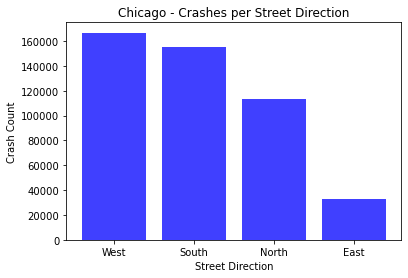

In [21]:
#Baker
# Create direction facing bar graph (NSEW)
dir_values = crash_df["STREET_DIRECTION"].value_counts()
x = dir_values.index.values
y = dir_values.values
for i in range(len(x)):
    if x[i] == "N":
        x[i] = "North"
    elif x[i] == "S":
        x[i] = "South"
    elif x[i] == "E":
        x[i] = "East"
    elif x[i] == "W":
        x[i] = "West"
plt.bar(x, y, color='blue', alpha =.75, align='center')
plt.title("Chicago - Crashes per Street Direction")
plt.xlabel("Street Direction")
plt.ylabel("Crash Count")
plt.show()

In [ ]:
# Andrew
# Pull in dataset for moon phases
# Create crash count vs. moon phases